**Import libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

**Load Dataset**

In [3]:
dataset = pd.read_csv(r'C:\Users\Wisdom Duru\Downloads\nsclc_pd1_msk_2018_clinical_data.csv')
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0    Study ID                        240 non-null    object 
 1   Patient ID                       240 non-null    object 
 2   Sample ID                        240 non-null    object 
 3   Diagnosis Age                    240 non-null    int64  
 4   Cancer Type                      240 non-null    object 
 5   Cancer Type Detailed             240 non-null    object 
 6   Durable Clinical Benefit         240 non-null    object 
 7   FGA                              240 non-null    float64
 8   Fraction Genome Altered          240 non-null    float64
 9   Gene Panel                       240 non-null    object 
 10  IRB                              240 non-null    object 
 11  Lines of treatment               240 non-null    int64  
 12  Mutation Count        

,Study ID,Patient ID,Sample ID,Diagnosis Age,Cancer Type,Cancer Type Detailed,Durable Clinical Benefit,FGA,Fraction Genome Altered,Gene Panel,...,Oncotree Code,PD-L1 Score (%),Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sex,Smoker,Somatic Status,TMB (nonsynonymous),Treatment Type
0,nsclc_pd1_msk_2018,P-0000012,P-0000012-T03-IM3,58,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,YES,0.18,0.1844,IMPACT341,...,LUAD,NaN,27.20,0:Not Progressed,1,Female,Ever,Matched,32.165504,Combination
1,nsclc_pd1_msk_2018,P-0000082,P-0000082-T01-IM3,60,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,YES,0.36,0.3606,IMPACT341,...,LUAD,100.0,14.50,1:Progressed,1,Male,Ever,Matched,1.109155,Monotherapy
2,nsclc_pd1_msk_2018,P-0000208,P-0000208-T01-IM3,68,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NO,0.12,0.1173,IMPACT341,...,LUAD,3.0,4.17,1:Progressed,1,Female,Ever,Matched,2.218311,Monotherapy
3,nsclc_pd1_msk_2018,P-0000235,P-0000235-T01-IM3,77,Non-Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,NO,0.24,0.2380,IMPACT341,...,LUSC,NaN,0.60,1:Progressed,1,Male,Ever,Matched,8.873242,Monotherapy
4,nsclc_pd1_msk_2018,P-0000299,P-0000299-T01-IM3,66,Non-Small Cell Lung Cancer,Large Cell Neuroendocrine Carcinoma,NO,0.01,0.0051,IMPACT341,...,LUNE,NaN,1.63,1:Progressed,1,Male,Ever,Matched,7.764087,Combination


**Filter Non-Smokers and select key Genetic Features from dataset**

In [4]:
# Filter for non-smokers
non_smokers_dataset = dataset[dataset["Smoker"] == "Never"].copy()

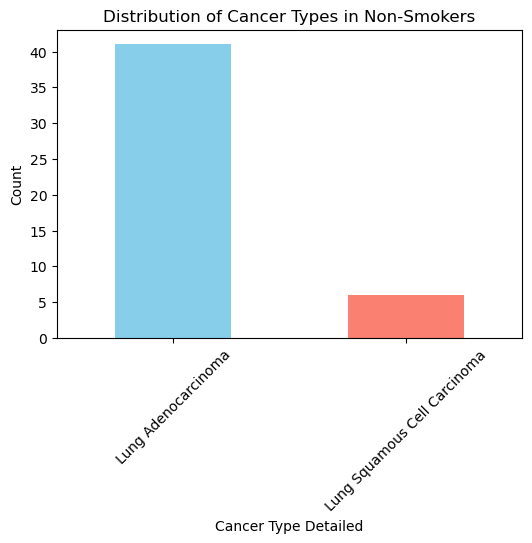

In [5]:
# Plot distribution of Cancer Type Detailed in non-smokers
plt.figure(figsize=(6, 4))
non_smokers_dataset["Cancer Type Detailed"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.xlabel("Cancer Type Detailed")
plt.ylabel("Count")
plt.title("Distribution of Cancer Types in Non-Smokers")
plt.xticks(rotation=45)
plt.show()


In [6]:
# Select relevant genetic alteration features
genetic_features = ["TMB (nonsynonymous)", "Mutation Count", "Fraction Genome Altered", "Cancer Type Detailed"]

# Summary statistics for risk threshold determination
non_smokers_dataset[genetic_features].describe(include ="all")

,TMB (nonsynonymous),Mutation Count,Fraction Genome Altered,Cancer Type Detailed
count,47.000000,47.000000,47.000000,47
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,Lung Adenocarcinoma
freq,NaN,NaN,NaN,41
mean,4.472212,4.489362,0.168219,NaN
std,2.852997,2.819747,0.177442,NaN
min,0.978720,1.000000,0.000000,NaN
25%,2.936159,3.000000,0.028550,NaN
50%,3.914879,4.000000,0.131400,NaN
75%,5.366983,6.000000,0.276750,NaN


**Define Levels of Risks**

In [7]:
# Define new risk categories: High Risk (1), Medium Risk (0.5), Low Risk (0)
def classify_risk(row):
    if row["Cancer Type Detailed"] == "Lung Adenocarcinoma":
        if (row["TMB (nonsynonymous)"] >= 5.37) or (row["Mutation Count"] >= 6) or (row["Fraction Genome Altered"] >= 0.28):
            return 1  # High Risk: LUAD + high genetic markers
        else:
            return 0.5  # Medium Risk: LUAD but without high genetic markers
    else:
        return int(
            (row["TMB (nonsynonymous)"] >= 5.37) or 
            (row["Mutation Count"] >= 6) or 
            (row["Fraction Genome Altered"] >= 0.28)
        )

# Apply the new classification
non_smokers_dataset["Risk Level"] = non_smokers_dataset.apply(classify_risk, axis=1)

# Check distribution of new risk levels
non_smokers_dataset["Risk Level"].value_counts()



Risk Level
1.0    22
0.5    22
0.0     3
Name: count, dtype: int64

C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_10580\2007551338.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset["Diagnosis Age"], palette="coolwarm")


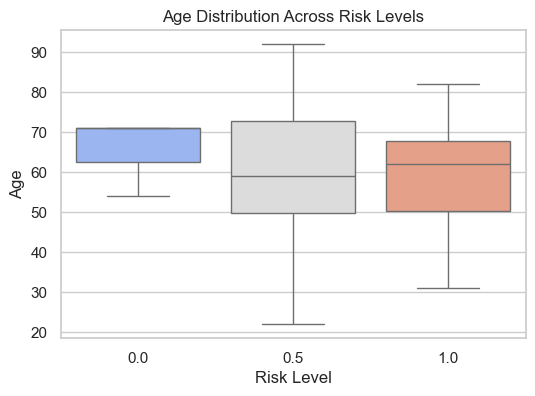

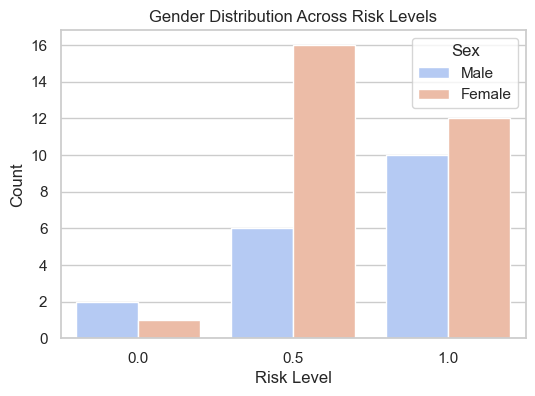

In [8]:
# Set plot style
sns.set(style="whitegrid")

# 🔹 Boxplot: Age vs. Risk Level
plt.figure(figsize=(6, 4))
sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset["Diagnosis Age"], palette="coolwarm")
plt.xlabel("Risk Level")
plt.ylabel("Age")
plt.title("Age Distribution Across Risk Levels")
plt.show()

# 🔹 Bar Chart: Gender vs. Risk Level
plt.figure(figsize=(6, 4))
sns.countplot(x=non_smokers_dataset["Risk Level"], hue=non_smokers_dataset["Sex"], palette="coolwarm")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.title("Gender Distribution Across Risk Levels")
plt.legend(title="Sex")
plt.show()

**Visualizing the Major features**

C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_10580\3570384045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")
C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_10580\3570384045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")
C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_10580\3570384045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


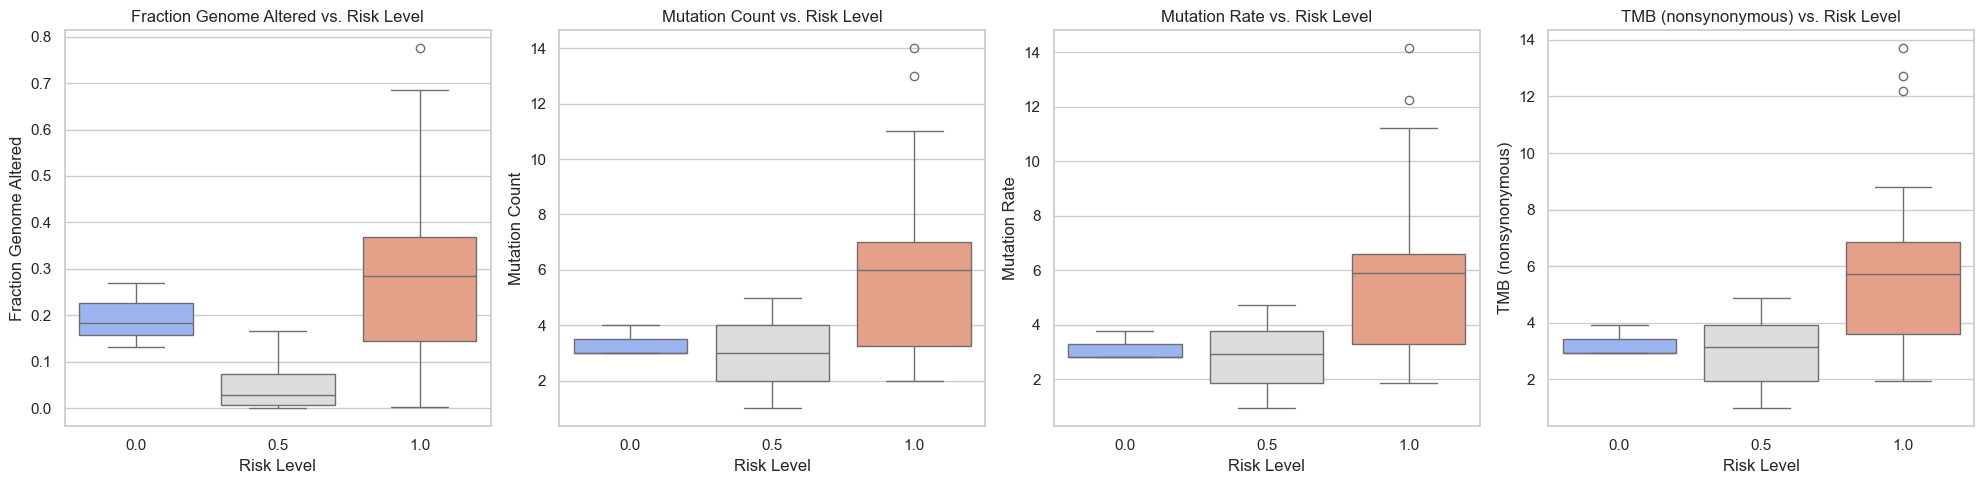

In [9]:
# Select top most important features
top_features = ["Fraction Genome Altered", "Mutation Count", "Mutation Rate","TMB (nonsynonymous)"]

# Set plot style
sns.set(style="whitegrid")

# Create subplots for boxplots (feature vs. risk level)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Generate boxplots
for i, feature in enumerate(top_features):
    sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"{feature} vs. Risk Level")
    axes[i].set_xlabel("Risk Level")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

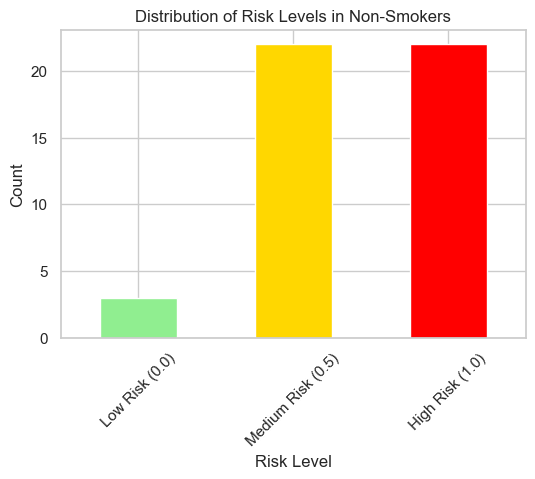

In [10]:
# Plot distribution of Risk Levels
plt.figure(figsize=(6, 4))
non_smokers_dataset["Risk Level"].value_counts().sort_index().plot(kind="bar", color=["lightgreen", "gold", "red"])
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.title("Distribution of Risk Levels in Non-Smokers")
plt.xticks(ticks=[0, 1, 2], labels=["Low Risk (0.0)", "Medium Risk (0.5)", "High Risk (1.0)"], rotation=45)
plt.show()


**Feature Scaling**

In [11]:
# Ensure 'Cancer Type Detailed' is encoded properly
non_smokers_dataset["Cancer_Type_Encoded"] = LabelEncoder().fit_transform(non_smokers_dataset["Cancer Type Detailed"])

In [12]:
# Create interaction terms
non_smokers_dataset["Mutation_FGA_Interaction"] = non_smokers_dataset["Mutation Count"] * non_smokers_dataset["Fraction Genome Altered"]
non_smokers_dataset["TMB_Mutation_Interaction"] = non_smokers_dataset["TMB (nonsynonymous)"] * non_smokers_dataset["Mutation Count"]

**PCA**

In [13]:
# Apply PCA to genetic features
genetic_features_pca = ["TMB (nonsynonymous)", "Mutation Count", "Fraction Genome Altered", "Mutation Rate"]
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(non_smokers_dataset[genetic_features_pca])
non_smokers_dataset["PCA_1"] = pca_transformed[:, 0]
non_smokers_dataset["PCA_2"] = pca_transformed[:, 1]


**Cluster Genetic features**

In [14]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
non_smokers_dataset["Genetic_Cluster"] = kmeans.fit_predict(non_smokers_dataset[genetic_features_pca])

c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [15]:
# Final feature set
enhanced_features = [
    "Fraction Genome Altered", "Mutation Count", "Mutation Rate", "Sex", "Diagnosis Age",
    "Mutation_FGA_Interaction", "TMB_Mutation_Interaction", "PCA_1", "PCA_2", "Genetic_Cluster", "Cancer_Type_Encoded"
]

**Correlation matrix**

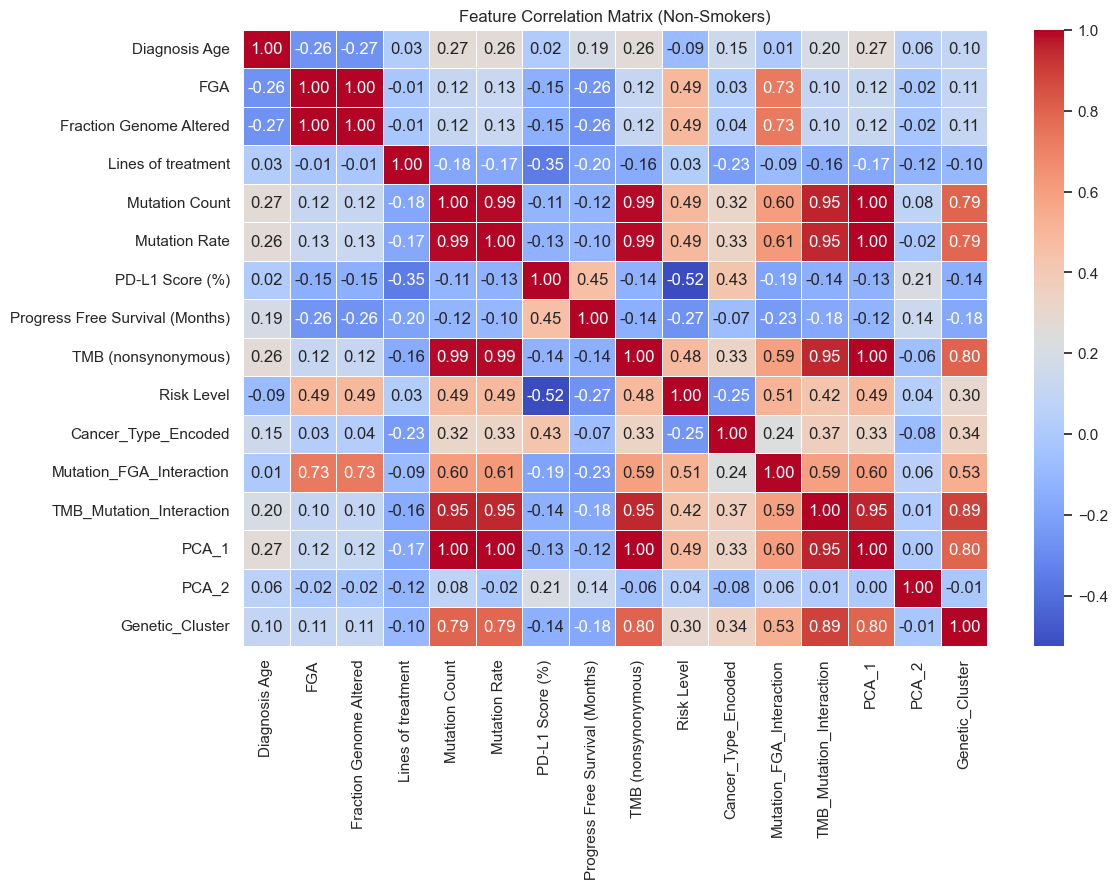

In [16]:
# Select only numeric columns
numeric_df = non_smokers_dataset.select_dtypes(include=["number"]).drop(columns=["Number of Samples Per Patient"], errors="ignore")

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Matrix (Non-Smokers)")
plt.show()

**TRAINING THE SVM MODEL WITH RBF KERNEL**

In [17]:
# Convert risk levels into categorical classes
y_risk_class = non_smokers_dataset["Risk Level"].map({0.0: 0, 0.5: 1, 1.0: 2})  # Mapping to class labels


In [18]:
# Ensure all features are numeric
X_risk_fixed = non_smokers_dataset[enhanced_features]
X_risk_fixed = X_risk_fixed.loc[:, ~X_risk_fixed.columns.duplicated()]  # Remove duplicates if any

In [19]:
# Split data again with 30% test size
X_train_risk_class, X_test_risk_class, y_train_risk_class, y_test_risk_class = train_test_split(
    X_risk_fixed, y_risk_class, test_size=0.3, random_state=0, stratify=y_risk_class
)

In [20]:
# Perform one-hot encoding
X_train_risk_class = pd.get_dummies(X_train_risk_class, columns=['Sex'], drop_first=True)
X_test_risk_class = pd.get_dummies(X_test_risk_class, columns=['Sex'], drop_first=True)

In [21]:
# Standardize features
scaler_risk_class = StandardScaler()
X_train_scaled_risk_class = scaler_risk_class.fit_transform(X_train_risk_class)
X_test_scaled_risk_class = scaler_risk_class.transform(X_test_risk_class)

In [22]:
print(X_train_risk_class.dtypes)

Fraction Genome Altered     float64
Mutation Count                int64
Mutation Rate               float64
Diagnosis Age                 int64
Mutation_FGA_Interaction    float64
TMB_Mutation_Interaction    float64
PCA_1                       float64
PCA_2                       float64
Genetic_Cluster               int32
Cancer_Type_Encoded           int32
Sex_Male                       bool
dtype: object


In [23]:
# Train SVM with RBF kernel for multi-class classification
svm_risk_class_model = SVC(kernel="rbf", C=1, gamma= "scale", probability=True, random_state=0)
svm_risk_class_model.fit(X_train_scaled_risk_class, y_train_risk_class)

SVC(C=1, probability=True, random_state=0)

In [24]:
# Evaluate model performance
train_acc_risk_class = svm_risk_class_model.score(X_train_scaled_risk_class, y_train_risk_class)
test_acc_risk_class = svm_risk_class_model.score(X_test_scaled_risk_class, y_test_risk_class)


In [25]:
# Output results
(train_acc_risk_class, test_acc_risk_class)

(0.96875, 0.9333333333333333)

In [26]:
# Make predictions on the entire test set
y_pred = svm_risk_class_model.predict(X_test_scaled_risk_class)

# Compare predicted vs. actual risk levels
comparison_df = pd.DataFrame({
    "Actual Risk Level": y_test_risk_class.values,
    "Predicted Risk Level": y_pred
})

# Display the first few comparisons
print(comparison_df.head())
print(comparison_df.info())

# Calculate accuracy
accuracy = (comparison_df["Actual Risk Level"] == comparison_df["Predicted Risk Level"]).mean()
print(f"Model Accuracy on Test Set: {accuracy:.2%}")


   Actual Risk Level  Predicted Risk Level
0                  1                     1
1                  1                     1
2                  2                     2
3                  2                     2
4                  2                     2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Actual Risk Level     15 non-null     int64
 1   Predicted Risk Level  15 non-null     int64
dtypes: int64(2)
memory usage: 372.0 bytes
None
Model Accuracy on Test Set: 93.33%


In [27]:
# Select the first row from the test set
instance_1 = X_test_risk_class.iloc[[0]]  # First row (index 0)
actual_risk_1 = y_test_risk_class.iloc[0]  # Actual risk level

# Standardize the instance using the same scaler
instance_1_scaled = scaler_risk_class.transform(instance_1)

# Make prediction
predicted_risk_1 = svm_risk_class_model.predict(instance_1_scaled)


# Display the results
print(f"Row 1 - Actual Risk Level: {actual_risk_1}")
print(f"Row 1 - Predicted Risk Level: {predicted_risk_1[0]}")



Row 1 - Actual Risk Level: 1
Row 1 - Predicted Risk Level: 1


**RANDOM FOREST AND DECISION TREE**

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# Initialize models
dt_model = DecisionTreeClassifier(random_state=0)
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)


# Train the models
dt_model.fit(X_train_scaled_risk_class, y_train_risk_class)
rf_model.fit(X_train_scaled_risk_class, y_train_risk_class)

# Make predictions
y_pred_dt = dt_model.predict(X_test_scaled_risk_class)
y_pred_rf = rf_model.predict(X_test_scaled_risk_class)

# Compute probability scores for ROC-AUC
y_probs_dt = dt_model.predict_proba(X_test_scaled_risk_class)
y_probs_rf = rf_model.predict_proba(X_test_scaled_risk_class)


# Compute Accuracy
accuracy_dt = accuracy_score(y_test_risk_class, y_pred_dt)
accuracy_rf = accuracy_score(y_test_risk_class, y_pred_rf)

# Compute ROC-AUC Score
roc_auc_dt = roc_auc_score(y_test_risk_class, y_probs_dt, multi_class="ovr")
roc_auc_rf = roc_auc_score(y_test_risk_class, y_probs_rf, multi_class="ovr")

# Generate Classification Reports
report_dt = classification_report(y_test_risk_class, y_pred_dt)
report_rf = classification_report(y_test_risk_class, y_pred_dt)



# Print Evaluation Metrics
print(f"Decision Tree Accuracy: {accuracy_dt:.2%}")
print(f"Random Forest Accuracy: {accuracy_rf:.2%}")
print(f"Decision Tree ROC-AUC: {roc_auc_dt:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")

print("\nDecision Tree Classification Report:\n", report_dt)
print("\nRandom Forest Classification Report:\n", report_rf)


Decision Tree Accuracy: 66.67%
Random Forest Accuracy: 86.67%
Decision Tree ROC-AUC: 0.64
Random Forest ROC-AUC: 0.99

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.86      0.80         7
           2       0.67      0.57      0.62         7

    accuracy                           0.67        15
   macro avg       0.47      0.48      0.47        15
weighted avg       0.66      0.67      0.66        15


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.86      0.80         7
           2       0.67      0.57      0.62         7

    accuracy                           0.67        15
   macro avg       0.47      0.48      0.47        15
weighted avg       0.66      0.67      0.66        15



**Classification Report**

In [39]:
from sklearn.metrics import classification_report


# Compute ROC-AUC score
y_probs = svm_risk_class_model.predict_proba(X_test_scaled_risk_class)
roc_auc = roc_auc_score(y_test_risk_class, y_probs, multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.2f}")
# Generate classification report
print(classification_report(y_test_risk_class, y_pred))

ROC-AUC Score: 0.62
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         7
           2       0.88      1.00      0.93         7

    accuracy                           0.93        15
   macro avg       0.62      0.67      0.64        15
weighted avg       0.88      0.93      0.90        15



c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Wisdom Duru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


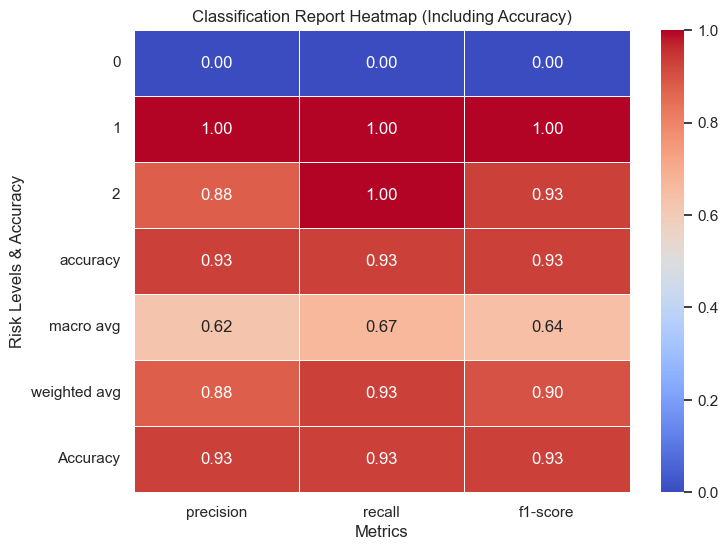

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(y_test_risk_class, y_pred, output_dict=True)

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()

# Extract accuracy value and add it as a new row
accuracy_value = report_df.loc["accuracy", "precision"]  # Extract accuracy score
report_df.loc["Accuracy"] = [accuracy_value, accuracy_value, accuracy_value, None]  # Duplicate across metrics

# Remove the support column for better visualization
report_df = report_df.drop(columns=["support"], errors="ignore")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set labels
plt.title("Classification Report Heatmap (Including Accuracy)")
plt.xlabel("Metrics")
plt.ylabel("Risk Levels & Accuracy")

plt.show()


**Confusion Matrix**

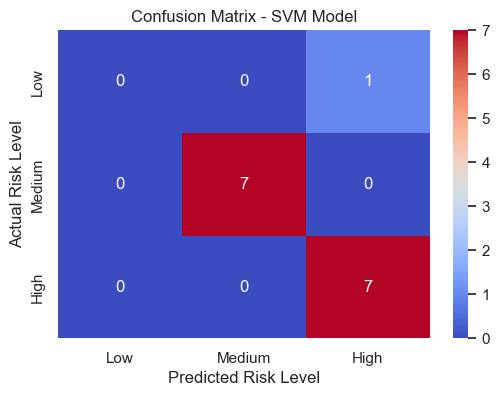

In [31]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_risk_class, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted Risk Level")
plt.ylabel("Actual Risk Level")
plt.title("Confusion Matrix - SVM Model")
plt.show()


**Visualization of the three models**

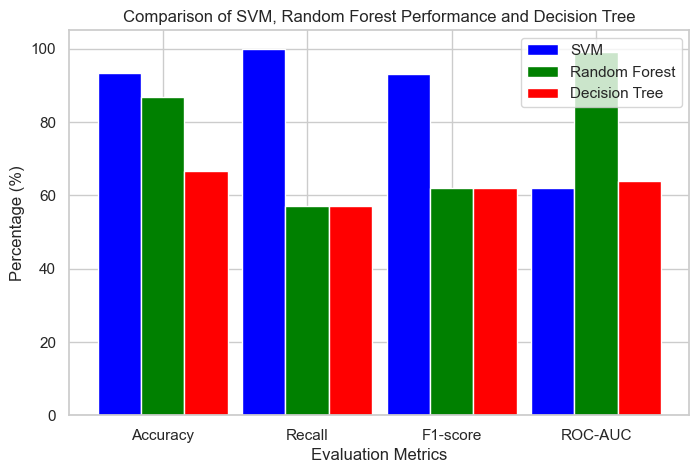

In [40]:
# Placeholder values for comparison (Replace these with actual computed values)
import numpy as np


svm_metrics = {"Accuracy": 93.30, "Recall": 100.00, "F1-score": 93.00, "ROC-AUC":62.00}
rf_metrics = {"Accuracy": 86.67, "Recall": 57.00, "F1-score": 62.00, "ROC-AUC":99.00}
dt_metrics = {"Accuracy": 66.67, "Recall": 57.00, "F1-score": 62.00, "ROC-AUC":64.00}

# Extract metric names and values
metrics = list(svm_metrics.keys())
svm_values = list(svm_metrics.values())
rf_values = list(rf_metrics.values())
dt_values = list(dt_metrics.values())

# Plot comparison bar chart
x = np.arange(len(metrics))
width = 0.3  

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, svm_values, width, label="SVM", color="blue")
bars2 = ax.bar(x , rf_values, width, label="Random Forest", color="green")
bars3 = ax.bar(x + width, dt_values, width, label="Decision Tree", color="red")

# Labels and formatting
ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("Percentage (%)")
ax.set_title("Comparison of SVM, Random Forest Performance and Decision Tree")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the chart
plt.show()

In [32]:
import joblib  

joblib.dump(svm_risk_class_model, "svm_lung_cancer_in_non_smokers_model.pkl")

print("Model saved successfully!")

Model saved successfully!
